In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

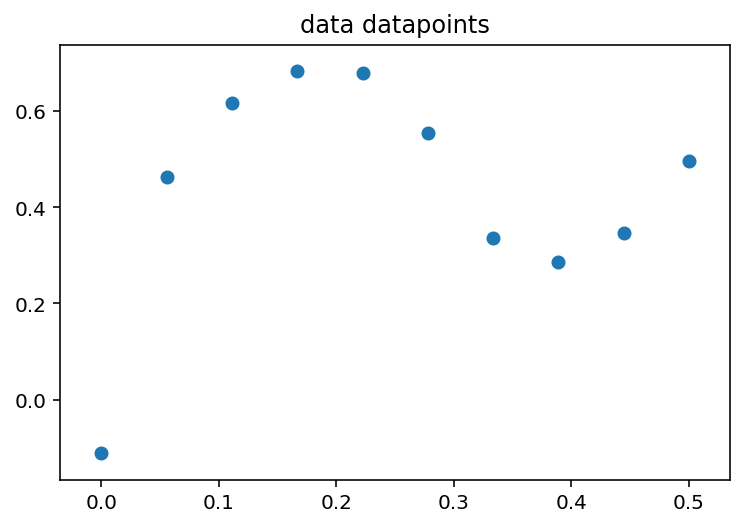

In [2]:
def function(x):
    
    N=torch.distributions.Normal(0,0.02)
    e=N.sample()
    return x+0.3*np.sin(2*np.pi*(x+e))+0.3*np.sin(4*np.pi*(x+e))+e

# toy dataset we can start with
x=torch.linspace(0,0.5,10).reshape(-1,1)
y=[]
for item in x:
    y.append(function(item))
y=torch.tensor(y).reshape(-1,1)

plt.scatter(x, y)
plt.title('data datapoints')
plt.show()

In [3]:
class standard_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1,32)
        self.l2 = nn.Linear(32,32)
        self.l3 = nn.Linear(32,1)
    def forward(self, x):
        x = self.l3(F.relu(self.l2(F.relu(self.l1(x)))))
        return x

In [4]:
net1 = standard_MLP()
criterion = nn.MSELoss()
optimizer = optim.SGD(net1.parameters(), lr=0.01)
epochs = 30000
Loss_re=[]
for epoch in range(epochs):
    optimizer.zero_grad()   
    output = net1(x)    
    loss = criterion(output, y)  
    Loss_re.append(loss.detach().numpy())
    if epoch % 5000 == 0:
        print("epoch {} loss: {}".format(epoch,loss))
    loss.backward()
    optimizer.step()

epoch 0 loss: 0.20295704901218414
epoch 5000 loss: 0.02479087933897972
epoch 10000 loss: 0.009555958211421967
epoch 15000 loss: 0.006885355804115534
epoch 20000 loss: 0.005470179487019777
epoch 25000 loss: 0.004298364277929068


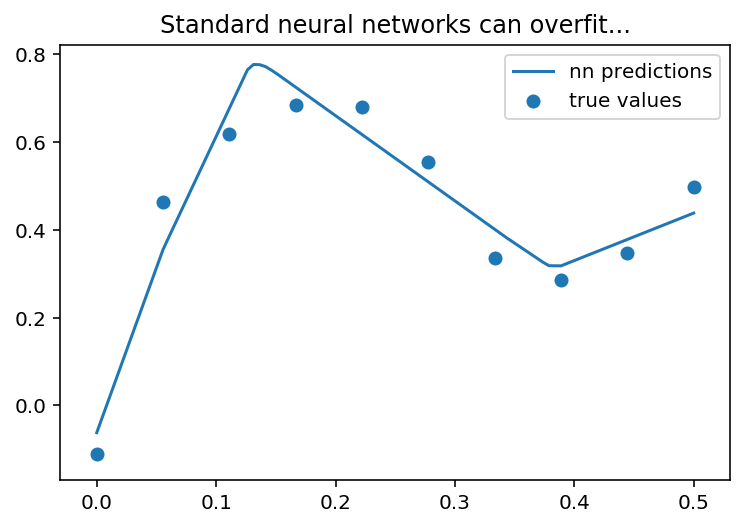

In [5]:
x_test = torch.linspace(0,0.5,100).reshape(-1,1)
predictions = net1(x_test)
plt.plot(x_test.numpy(), predictions.detach().numpy(), label = 'nn predictions')

plt.scatter(x, y, label = 'true values')
plt.title('Standard neural networks can overfit...')
plt.legend()
plt.show()

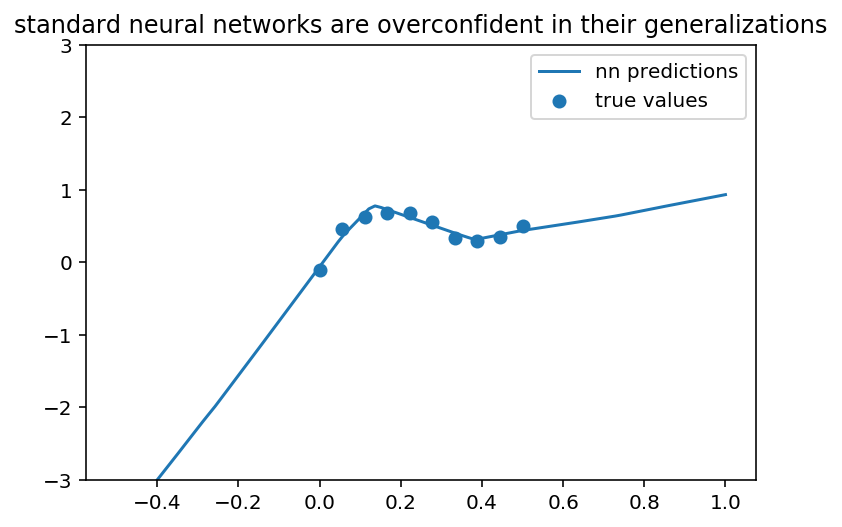

In [6]:
x_test = torch.linspace(-0.5,1,100).reshape(-1,1)
predictions = net1(x_test)
plt.plot(x_test.numpy(), predictions.detach().numpy(), label = 'nn predictions')
plt.scatter(x, y, label = 'true values')
plt.title('standard neural networks are overconfident in their generalizations')
plt.ylim(-3,3)
plt.legend()
plt.savefig("standard NN")
plt.show()

In [7]:
class Layer_BbB(nn.Module):
    def __init__(self, input_features, output_features, prior_var=1.0):
        
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # initialize w1 and w2 as μ and σ for weights
        self.w1 = nn.Parameter(torch.zeros(output_features, input_features))
        self.w2 = nn.Parameter(torch.zeros(output_features, input_features))
        # initialize b1 and b2 as μ and σ for bias
        self.b1 =  nn.Parameter(torch.zeros(output_features))
        self.b2 = nn.Parameter(torch.zeros(output_features))        
        self.w = None
        self.b = None
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        w_eps = Normal(0,1).sample(self.w1.shape)
        self.w = self.w1 + torch.log(1+torch.exp(self.w2)) * w_eps

        b_eps = Normal(0,1).sample(self.b1.shape)
        self.b = self.b1 + torch.log(1+torch.exp(self.b2)) * b_eps

        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        self.w_post = Normal(self.w1.data, torch.log(1+torch.exp(self.w2)))
        self.b_post = Normal(self.b1.data, torch.log(1+torch.exp(self.b2)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        out = F.linear(input, self.w, self.b)
        
        return out

In [8]:
class NN_BbB(nn.Module):
    def __init__(self, hidden_units, noise=0.1,  prior_var=1.0):
        super().__init__()
        self.h1 = Layer_BbB(1,hidden_units, prior_var=prior_var)      
        self.h2 = Layer_BbB(hidden_units, 1, prior_var=prior_var)
        self.noise = noise
        
    def loss(self, input, target, samples):   
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) 
            log_priors[i] = self.log_prior()
            log_posts[i] = self.log_post()
            log_likes[i] = Normal(outputs[i], self.noise).log_prob(target.reshape(-1)).sum() 
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        loss = log_post - log_prior - log_like
        return loss
    def log_prior(self):
        return self.h1.log_prior + self.h2.log_prior

    def log_post(self):
        return self.h1.log_post + self.h2.log_post
    
    def forward(self, x):
        x = torch.sigmoid(self.h1(x))
        x = self.h2(x)
        return x

In [11]:
net = NN_BbB(32, prior_var=10)
LR = 0.01
optimizer = optim.Adam(net.parameters(),lr = LR)

Loss_re=[]
epochs = 30000
for epoch in range(epochs):  
    
#     if epoch > 20000 and epoch % 100 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.9
    
    optimizer.zero_grad()
    loss = net.loss(x, y, 1)
    Loss_re.append(loss)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/30000
Loss: 1797.645263671875
epoch: 101/30000
Loss: 565.099853515625
epoch: 201/30000
Loss: 258.0350341796875
epoch: 301/30000
Loss: 802.9217529296875
epoch: 401/30000
Loss: 4162.841796875
epoch: 501/30000
Loss: 284.9907531738281
epoch: 601/30000
Loss: 617.7732543945312
epoch: 701/30000
Loss: 868.5638427734375
epoch: 801/30000
Loss: 301.45526123046875
epoch: 901/30000
Loss: 302.3993835449219
epoch: 1001/30000
Loss: 254.39117431640625
epoch: 1101/30000
Loss: 317.27789306640625
epoch: 1201/30000
Loss: 666.191162109375
epoch: 1301/30000
Loss: 270.6694030761719
epoch: 1401/30000
Loss: 471.70709228515625
epoch: 1501/30000
Loss: 292.81402587890625
epoch: 1601/30000
Loss: 259.82965087890625
epoch: 1701/30000
Loss: 456.0928955078125
epoch: 1801/30000
Loss: 254.28907775878906
epoch: 1901/30000
Loss: 392.85980224609375
epoch: 2001/30000
Loss: 322.0801086425781
epoch: 2101/30000
Loss: 265.7476806640625
epoch: 2201/30000
Loss: 359.5367431640625
epoch: 2301/30000
Loss: 244.86251831054688


epoch: 19201/30000
Loss: 96.0354995727539
epoch: 19301/30000
Loss: 98.83480834960938
epoch: 19401/30000
Loss: 98.7738265991211
epoch: 19501/30000
Loss: 111.13560485839844
epoch: 19601/30000
Loss: 97.6229248046875
epoch: 19701/30000
Loss: 100.2499008178711
epoch: 19801/30000
Loss: 101.76759338378906
epoch: 19901/30000
Loss: 101.6424331665039
epoch: 20001/30000
Loss: 108.6790771484375
epoch: 20101/30000
Loss: 105.98025512695312
epoch: 20201/30000
Loss: 102.72264099121094
epoch: 20301/30000
Loss: 100.47064208984375
epoch: 20401/30000
Loss: 103.44727325439453
epoch: 20501/30000
Loss: 101.07167053222656
epoch: 20601/30000
Loss: 92.93394470214844
epoch: 20701/30000
Loss: 99.57008361816406
epoch: 20801/30000
Loss: 103.73737335205078
epoch: 20901/30000
Loss: 99.25690460205078
epoch: 21001/30000
Loss: 93.1524429321289
epoch: 21101/30000
Loss: 105.11357116699219
epoch: 21201/30000
Loss: 93.37154388427734
epoch: 21301/30000
Loss: 88.0213394165039
epoch: 21401/30000
Loss: 95.18933868408203
epoch: 

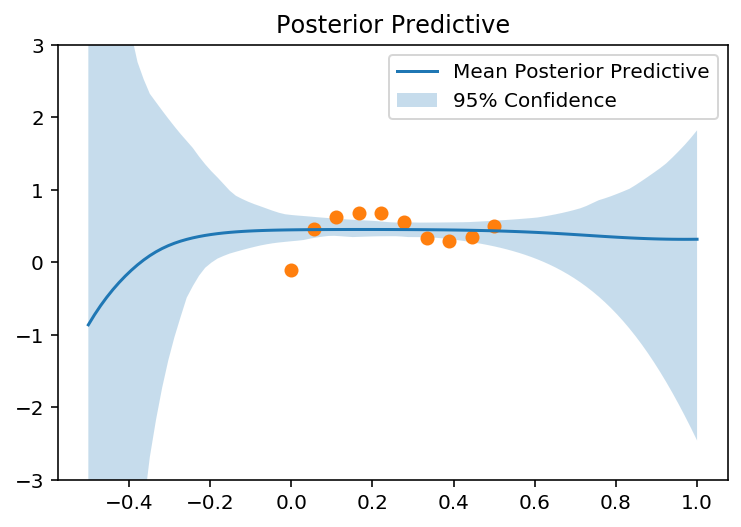

In [12]:
#make predictions for the points out of range of training set
samples = 100
x_test = torch.linspace(-0.5,1,100).reshape(-1,1)
y_test = np.zeros((samples,100))
for s in range(samples):
    y1 = net(x_test).detach().numpy()
    y_test[s] = y1.reshape(-1)
plt.plot(x_test.numpy(), np.mean(y_test, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_test.numpy().reshape(-1), np.percentile(y_test, 2.5, axis = 0), np.percentile(y_test, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.ylim(-3,3)
plt.legend()
plt.scatter(x, y)
plt.title('Posterior Predictive')
plt.show()